# Updation of previous model with Adaptive Moment Estimation (Adam) optimizer

In [1]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam # Import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau # Import ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# MobileNetV2 is commonly trained on 224x224 images
height = 224
width = 224

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(height, width, 3))

In [4]:
# --- Data Loading and Augmentation ---
train_dir = "dataset/training"
validation_dir = "dataset/validation"
batch_size = 8

In [5]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # Use MobileNetV2's preprocess_input
    rotation_range=90, # Data Augmentation
    horizontal_flip=True,
    vertical_flip=True
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(height, width),
    batch_size=batch_size
)

Found 2774 images belonging to 2 classes.


In [6]:
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 592 images belonging to 2 classes.


In [7]:
def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers for classification
    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        x = Dense(fc, activation='relu')(x)
        x = Dropout(dropout)(x)

    predictions = Dense(num_classes, activation='softmax')(x)

    finetune_model = Model(inputs=base_model.input, outputs=predictions)
    return finetune_model

In [8]:
class_list = ['Real', 'Fake']
FC_Layers = [1024, 1024]
dropout = 0.5

finetune_model = build_finetune_model(
    base_model,
    dropout=dropout,
    fc_layers=FC_Layers,
    num_classes=len(class_list)
)

In [9]:
num_epochs = 20
num_train_images = 2774
num_validation_images = 592

In [10]:
# Callbacks for saving the best model and stopping early
checkpoint = ModelCheckpoint(
    "MobileNetV2_model_improved.h5", # Using a new name for the improved model
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch'
)
early = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=10, # Can be reduced as the scheduler will help
    verbose=1,
    mode="auto"
)

# We are using ReduceLROnPlateau, which will reduce the learning rate when a metric (validation_accuracy) has stopped improving.

In [11]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    verbose=1,
    min_lr=0.00001
)

# Compile the model with the Adam optimizer
optimizer = Adam(learning_rate=0.001)
finetune_model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizer,
    metrics=['accuracy']
)

callbacks = [checkpoint, early, reduce_lr]

In [12]:
history = finetune_model.fit(
    train_generator,
    steps_per_epoch=num_train_images // batch_size,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=num_validation_images // batch_size, # Corrected validation_steps
    callbacks=callbacks # Use the new callbacks list
)

c:\Users\PRATYAOY SARKAR\FinalYrProject\myenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6224 - loss: 19.4897
Epoch 1: val_accuracy improved from None to 0.78041, saving model to MobileNetV2_model_improved.h5


346/346 ━━━━━━━━━━━━━━━━━━━━ 446s 1s/step - accuracy: 0.6840 - loss: 10.7124 - val_accuracy: 0.7804 - val_loss: 1.1625 - learning_rate: 0.0010
Epoch 2/20
  1/346 ━━━━━━━━━━━━━━━━━━━━ 7:37 1s/step - accuracy: 1.0000 - loss: 0.0012

c:\Users\PRATYAOY SARKAR\FinalYrProject\myenv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.78041
346/346 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.7804 - val_loss: 1.1787 - learning_rate: 0.0010
Epoch 3/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7505 - loss: 1.4765
Epoch 3: val_accuracy improved from 0.78041 to 0.81588, saving model to MobileNetV2_model_improved.h5


346/346 ━━━━━━━━━━━━━━━━━━━━ 413s 1s/step - accuracy: 0.7650 - loss: 1.0522 - val_accuracy: 0.8159 - val_loss: 0.5195 - learning_rate: 0.0010
Epoch 4/20
  1/346 ━━━━━━━━━━━━━━━━━━━━ 6:28 1s/step - accuracy: 0.8750 - loss: 0.3064
Epoch 4: val_accuracy improved from 0.81588 to 0.82095, saving model to MobileNetV2_model_improved.h5


346/346 ━━━━━━━━━━━━━━━━━━━━ 26s 73ms/step - accuracy: 0.8750 - loss: 0.3064 - val_accuracy: 0.8209 - val_loss: 0.5122 - learning_rate: 0.0010
Epoch 5/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7706 - loss: 0.6677
Epoch 5: val_accuracy did not improve from 0.82095
346/346 ━━━━━━━━━━━━━━━━━━━━ 430s 1s/step - accuracy: 0.7730 - loss: 0.6059 - val_accuracy: 0.6554 - val_loss: 0.6098 - learning_rate: 0.0010
Epoch 6/20
  1/346 ━━━━━━━━━━━━━━━━━━━━ 6:08 1s/step - accuracy: 0.7500 - loss: 0.3688
Epoch 6: val_accuracy did not improve from 0.82095
346/346 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.7500 - loss: 0.3688 - val_accuracy: 0.6470 - val_loss: 0.6173 - learning_rate: 0.0010
Epoch 7/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7342 - loss: 0.6214
Epoch 7: val_accuracy did not improve from 0.82095
346/346 ━━━━━━━━━━━━━━━━━━━━ 405s 1s/step - accuracy: 0.7491 - loss: 0.5987 - val_accuracy: 0.7821 - val_loss: 0.4988 - learning_rate: 0.0010
Epoch 8/20
  1/346 ━

In [13]:
MODEL_PATH = "MobileNetV2_model_improved.h5" 

model = load_model(MODEL_PATH)
true_labels = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

predictions = model.predict(validation_generator)
predicted_labels = np.argmax(predictions, axis=1)


74/74 ━━━━━━━━━━━━━━━━━━━━ 28s 297ms/step


In [14]:
from sklearn.metrics import classification_report, accuracy_score

In [15]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Printing the final accuracy values
print(f"Final Training Accuracy: {train_acc[-1]:.4f}")
print(f"Final Validation Accuracy: {val_acc[-1]:.4f}")

Final Training Accuracy: 0.7500
Final Validation Accuracy: 0.6740


In [16]:
print("--- Model Evaluation Report ---")
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}\n")

# Print precision, recall, f1-score for each class
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_labels))

--- Model Evaluation Report ---
Accuracy: 0.8209

Classification Report:
              precision    recall  f1-score   support

        fake       0.77      0.92      0.84       296
        real       0.90      0.73      0.80       296

    accuracy                           0.82       592
   macro avg       0.83      0.82      0.82       592
weighted avg       0.83      0.82      0.82       592



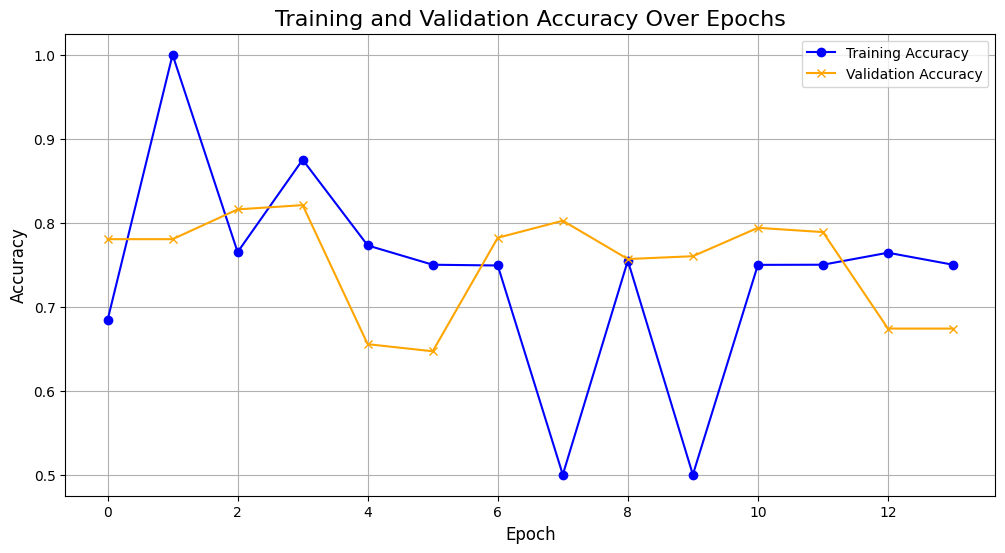

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(train_acc, label='Training Accuracy', color='blue', marker='o')
plt.plot(val_acc, label='Validation Accuracy', color='orange', marker='x')

# Adding titles and labels for clarity
plt.title('Training and Validation Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='best')
plt.grid(True)

# Display the plot
plt.show()